In [365]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

c:\Users\Luis\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [366]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [367]:
df_test = pd.read_feather('test_normalized_data.fth')

- Para verificar que columnas tiene originalmente tests. Por ejemplo, como es de esperar, la columna customers no es dato y podría intentar estimarse tambien
- Es bastante discutible usar el clima y temperatura (Se puede usar el forecast si es en el futuro
- En un caso real no parece sensato usar google trend

In [368]:
df_test.columns

Index(['index', 'Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCove

In [369]:
df = pd.read_feather('train_normalized_data.fth')

In [370]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', ]
            #'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

In [371]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [372]:
DataFrameSummary(df[cat_vars]).summary().loc[['uniques', 'types']]

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State
uniques,1115,7,3,12,31,4,25,26,4,3,4,21,8,12
types,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


In [373]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [374]:
uniques

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State
uniques,1115,7,3,12,31,4,25,26,4,3,4,21,8,12


# Asignación de dimensión de embeddings

In [375]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 4, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

## Ejemplo con DayOfWeek, store y CompetitionDistance

In [376]:
uniques['DayOfWeek'][0]

C:\Users\Luis\AppData\Local\Temp\ipykernel_5668\2408409433.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  uniques['DayOfWeek'][0]


7

In [377]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, Concatenate

In [378]:
day_of_week_input = Input(shape=(1,), name="day_of_week_input")
store_input = Input(shape=(1,), name="store_input")
# Por ser continua competition_distance no necesita embeddings
competition_distance_input = Input(shape=(1,), name="competition_distance_input")
#Una vez definidas las capas las conecto:
day_of_week_Embedd_out = Embedding(uniques['DayOfWeek'][0], cat_var_dict['DayOfWeek'], name="day_of_week_Embedd")(day_of_week_input)
store_Embedd_out = Embedding(uniques['Store'][0], cat_var_dict['Store'], name="store_Embedd")(store_input)

C:\Users\Luis\AppData\Local\Temp\ipykernel_5668\1738997712.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day_of_week_Embedd_out = Embedding(uniques['DayOfWeek'][0], cat_var_dict['DayOfWeek'], name="day_of_week_Embedd")(day_of_week_input)
C:\Users\Luis\AppData\Local\Temp\ipykernel_5668\1738997712.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  store_Embedd_out = Embedding(uniques['Store'][0], cat_var_dict['Store'], name="store_Embedd")(store_input)


In [379]:
print(f'Entradas: {day_of_week_input.shape}, {store_input.shape}')
print(f'Salidas: {day_of_week_Embedd_out.shape}, {store_Embedd_out.shape}')

Entradas: (None, 1), (None, 1)
Salidas: (None, 1, 4), (None, 1, 50)


In [380]:
day_of_week_Embedd_flat = Flatten(name="day_of_week_flat")(day_of_week_Embedd_out)
store_Embedd_flat = Flatten(name="store_flat")(store_Embedd_out)

In [381]:
merged = Concatenate(name='All_Concatenate')([day_of_week_Embedd_flat, store_Embedd_flat, competition_distance_input])

In [382]:
# Agregamos la red neuronal:
x = Dense(100, activation='relu')(merged)
x = Dense(50, activation='relu')(x)
output = Dense(1, activation='linear')(x)

In [383]:
# En el input hay una lista de tamaño 3:
model = Model([day_of_week_input, store_input, competition_distance_input], output)

In [384]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ day_of_week_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ store_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ day_of_week_Embedd  │ (None, 1, 4)      │         28 │ day_of_week_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ store_Embedd        │ (None, 1, 50)     │     55,750 │ store_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ day_of_week_flat    │ (None, 4)         │          0 │ day_of_week_Embe… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ store_flat          │ (None, 50)        │          0 │ store_Embedd[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ competition_distan… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ All_Concatenate     │ (None, 55)        │          0 │ day_of_week_flat… │
│ (Concatenate)       │                   │            │ store_flat[0][0], │
│                     │                   │            │ competition_dist… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 100)       │      5,600 │ All_Concatenate[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 50)        │      5,050 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │         51 │ dense_34[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,479 (259.68 KB)

 Trainable params: 66,479 (259.68 KB)

 Non-trainable params: 0 (0.00 B)

In [385]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]

In [386]:
print(f'Cantidad en val: {len(df_val)}, porcentaje de train: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje de train: 0.9642465458145908


In [387]:
df_train[['DayOfWeek', 'Store', 'CompetitionDistance']].values.shape

(814150, 3)

In [388]:
# Es value 3 al final porque splitea las 3 columnas por separado, el vector con los datos de la 1 variable, otro con la segunda y otro vect con la tercera:
X_train = np.hsplit(df_train[['DayOfWeek', 'Store', 'CompetitionDistance']].values, 3)
X_val = np.hsplit(df_val[['DayOfWeek', 'Store', 'CompetitionDistance']].values, 3)


In [389]:
len(X_train[2])

814150

In [390]:
len(X_train)

3

In [391]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import TensorBoard

In [392]:
#def rmspe(y_true, y_pred):
  #  return k.sqrt(k.mean(k.square ((y_true - y_pred) / y_true)))

In [393]:
# Normalización de la salida, lo logico es normalizar la entrada.
y_mean = df_train['Sales'].mean()
y_std = df_train['Sales'].std()

# Escala logaritmica
# max_log_y = np.max(np.log(df['Sales']))
# y_train = np.log(df['Sales'])/max_log_y

In [394]:
y_train = (df_train['Sales'].values - y_mean)/y_std
y_val = (df_val['Sales'].values - y_mean)/y_std

In [356]:
y_train = df_train['Sales'].values.astype(float) 
y_val = df_val['Sales'].values.astype(float) 

In [395]:
y_train

array([-0.39169567,  0.93572683,  2.0284065 , ..., -0.61679154,
       -0.79172319, -0.31902186])

In [396]:
model.compile(optimizer=Adam(learning_rate=0.001), metrics=["mse"], loss="mse")

In [397]:
tb = TensorBoard (log_dir="logs", histogram_freq=3, embeddings_freq=3)

In [398]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=10, batch_size=256,callbacks=tb)

Epoch 1/10
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 4s 1000us/step - loss: 0.3909 - mse: 0.3909 - val_loss: 0.2417 - val_mse: 0.2417
Epoch 2/10
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 3s 947us/step - loss: 0.3138 - mse: 0.3138 - val_loss: 0.2359 - val_mse: 0.2359
Epoch 3/10
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 3s 962us/step - loss: 0.3087 - mse: 0.3087 - val_loss: 0.2337 - val_mse: 0.2337
Epoch 4/10
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 3s 947us/step - loss: 0.3079 - mse: 0.3079 - val_loss: 0.2349 - val_mse: 0.2349
Epoch 5/10
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 3s 926us/step - loss: 0.3071 - mse: 0.3071 - val_loss: 0.2358 - val_mse: 0.2358
Epoch 6/10
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 3s 940us/step - loss: 0.3063 - mse: 0.3063 - val_loss: 0.2306 - val_mse: 0.2306
Epoch 7/10
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 3s 947us/step - loss: 0.3050 - mse: 0.3050 - val_loss: 0.2284 - val_mse: 0.2284
Epoch 8/10
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 3s 949us/step - loss: 0.3036 - mse: 0.3036 - val_loss: 0.2354 - val_mse: 0.2354
Epoch 9/10
3181/3181 ━━

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [399]:
y_pred_norm = model.predict(X_val, verbose=1)
y_pred = y_pred_norm*y_std + y_mean
# y_pred = np.exp(model.predict(X_train)*max_log_y)

944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step


In [400]:
def root_mean_squared_error_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_pred - y_true)), axis=-1))

def rmspe_np(y_true, y_pred):
    MSEP_ = ((y_true - y_pred)/y_true)**2
    return np.sqrt(MSEP_.mean())

In [401]:
rmspe_np(df_val['Sales'].values, y_pred.reshape(-1))

0.21896005208300404

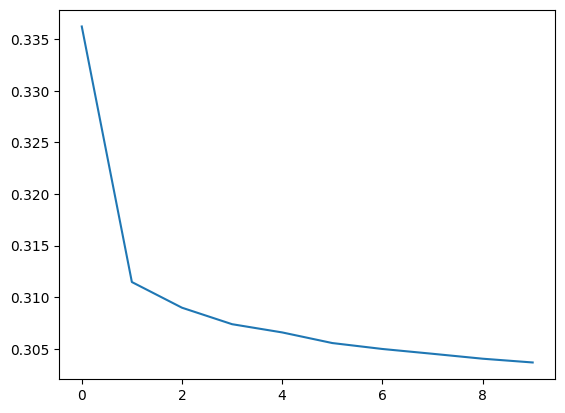

In [402]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.show()